import necessary packages

In [3]:
from torch.utils.tensorboard import SummaryWriter
import os
import sys
import glob

from torch.utils.data import DataLoader
import numpy as np
import torch
from torch import optim
import matplotlib.pyplot as plt
from natsort import natsorted
from torchvision import transforms

from MIR.models import SpatialTransformer, EncoderFeatureExtractor, SITReg, VFA, TransMorphTVF, TransMorph, convex_adam_MIND, VFASPR
from MIR.models.SITReg import ReLUFactory, GroupNormalizerFactory
from MIR.models.SITReg.composable_mapping import DataFormat
from MIR.models.SITReg.deformation_inversion_layer.fixed_point_iteration import (
    AndersonSolver,
    AndersonSolverArguments,
    MaxElementWiseAbsStopCriterion,
    RelativeL2ErrorStopCriterion,
)
import MIR.models.convexAdam.configs_ConvexAdam_MIND as CONFIGS_CVXAdam
import MIR.models.configs_TransMorph as configs_TransMorph
import MIR.models.configs_VFA as CONFIGS_VFA
from data import datasets, trans
import torch.nn.functional as F
from MIR.pretrained_wts import ModelWeights


/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define image size and dataset path

In [4]:
H, W, D = 160, 192, 224
data_dir = './IXI_data/'
pretrain_wts_dir = './pretrain_wts/'
os.makedirs(pretrain_wts_dir, exist_ok=True)
results_dir = './results/'
os.makedirs(results_dir, exist_ok=True)

Initialize models
We begin with TransMorph

In [5]:
def transmorph_model():
    scale_factor = 1
    config = configs_TransMorph.get_3DTransMorph3Lvl_config()
    config.img_size = (H//scale_factor, W//scale_factor, D//scale_factor)
    config.window_size = (H // 64, W // 64, D // 64)
    config.out_chan = 3
    print(config)
    TM_model = TransMorph(config, SVF=False)
    if not os.path.exists(os.path.join(pretrain_wts_dir, "TransMorph.pth.tar")):
        import gdown
        file_id = ModelWeights['TransMorph-IXI-Atlas2Subject']['wts']
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, os.path.join(pretrain_wts_dir, "TransMorph.pth.tar"), quiet=False)
    TM_model.load_state_dict(torch.load(os.path.join(pretrain_wts_dir, "TransMorph.pth.tar"))['state_dict'])
    return TM_model.cuda('cuda:0')

Then TransMorph-TVF

In [6]:
def transmorphTVF_model():
    scale_factor = 2
    config = configs_TransMorph.get_3DTransMorph3Lvl_config()
    config.img_size = (H//scale_factor, W//scale_factor, D//scale_factor)
    config.window_size = (H // 64, W // 64, D // 64)
    config.out_chan = 3
    print(config)
    TMTVF_model = TransMorphTVF(config, SVF=False)
    if not os.path.exists(os.path.join(pretrain_wts_dir, "TransMorphTVF.pth.tar")):
        import gdown
        file_id = ModelWeights['TransMorphTVF-IXI-Atlas2Subject']['wts']
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, os.path.join(pretrain_wts_dir, "TransMorphTVF.pth.tar"), quiet=False)
    TMTVF_model.load_state_dict(torch.load(os.path.join(pretrain_wts_dir, "TransMorphTVF.pth.tar"))['state_dict'])
    return TMTVF_model.cuda('cuda:0')

Then VFA

In [7]:
def vfa_model():
    scale_factor = 1
    config = CONFIGS_VFA.get_VFA_default_config()
    config.img_size = (H//scale_factor, W//scale_factor, D//scale_factor)
    print(config)
    VFA_model = VFA(config, device='cuda:0')
    if not os.path.exists(os.path.join(pretrain_wts_dir, "VFA.pth.tar")):
        import gdown
        file_id = ModelWeights['VFA-IXI-Atlas2Subject']['wts']
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, os.path.join(pretrain_wts_dir, "VFA.pth.tar"), quiet=False)
    VFA_model.load_state_dict(torch.load(os.path.join(pretrain_wts_dir, "VFA.pth.tar"))['state_dict'])
    return VFA_model.cuda()

def vfa_spr_model():
    scale_factor = 1
    config = CONFIGS_VFA.get_VFA_default_config()
    config.img_size = (H//scale_factor, W//scale_factor, D//scale_factor)
    print(config)
    VFASPR_model = VFASPR(config, device='cuda:0', SVF=True)
    if not os.path.exists(os.path.join(pretrain_wts_dir, "VFA_SPR.pth.tar")):
        import gdown
        file_id = ModelWeights['VFA-SPR-IXI-Atlas2Subject']['wts']
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, os.path.join(pretrain_wts_dir, "VFA_SPR.pth.tar"), quiet=False)
    VFASPR_model.load_state_dict(torch.load(os.path.join(pretrain_wts_dir, "VFA_SPR.pth.tar"))['state_dict'])
    return VFASPR_model.cuda()

Then SITReg

In [8]:
def create_model(INPUT_SHAPE) -> SITReg:
    """Create SITReg model from config"""
    feature_extractor = EncoderFeatureExtractor(
            n_input_channels=1,
            activation_factory=ReLUFactory(),
            n_features_per_resolution=[12, 16, 32, 64, 128, 128],
            n_convolutions_per_resolution=[2, 2, 2, 2, 2, 2],
            input_shape=INPUT_SHAPE,
            normalizer_factory=GroupNormalizerFactory(2),
        ).cuda()
    AndersonSolver_forward = AndersonSolver(
        MaxElementWiseAbsStopCriterion(min_iterations=2, max_iterations=50, threshold=1e-2),
        AndersonSolverArguments(memory_length=4),
    )
    AndersonSolver_backward = AndersonSolver(
        RelativeL2ErrorStopCriterion(min_iterations=2, max_iterations=50, threshold=1e-2),
        AndersonSolverArguments(memory_length=4),
    )
    network = SITReg(
        feature_extractor=feature_extractor,
        n_transformation_convolutions_per_resolution=[2, 2, 2, 2, 2, 2],
        n_transformation_features_per_resolution=[12, 64, 128, 256, 256, 256],
        max_control_point_multiplier=0.99,
        affine_transformation_type=None,
        input_voxel_size=(1.0, 1.0, 1.0),
        input_shape=INPUT_SHAPE,
        transformation_downsampling_factor=(1.0, 1.0, 1.0),
        forward_fixed_point_solver=AndersonSolver_forward,
        backward_fixed_point_solver=AndersonSolver_backward,
        activation_factory=ReLUFactory(),
        normalizer_factory=GroupNormalizerFactory(4),
            ).cuda()
    return network

def sitreg_model():
    sitreg_model = create_model((H, W, D))
    if not os.path.exists(os.path.join(pretrain_wts_dir, "SITReg.pth.tar")):
        import gdown
        file_id = ModelWeights['SITReg-IXI-Atlas2Subject']['wts']
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, os.path.join(pretrain_wts_dir, "SITReg.pth.tar"), quiet=False)
    sitreg_model.load_state_dict(torch.load(os.path.join(pretrain_wts_dir, "SITReg.pth.tar"))['state_dict'])
    return sitreg_model.cuda('cuda:0')

def sitreg_spr_model():
    sitreg_spr_model = create_model((H, W, D))
    if not os.path.exists(os.path.join(pretrain_wts_dir, "SITReg_SPR.pth.tar")):
        import gdown
        file_id = ModelWeights['SITReg-SPR-IXI-Atlas2Subject']['wts']
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, os.path.join(pretrain_wts_dir, "SITReg_SPR.pth.tar"), quiet=False)
    sitreg_spr_model.load_state_dict(torch.load(os.path.join(pretrain_wts_dir, "SITReg_SPR.pth.tar"))['state_dict'])
    return sitreg_spr_model.cuda('cuda:0')

Then ConvexAdam-MIND

In [9]:
def convexadam_model():
    config = CONFIGS_CVXAdam.get_ConvexAdam_MIND_brain_default_config()
    model = convex_adam_MIND
    return {'model': model, 'config': config}

Then deedsBCV (this is only available on Linux)

In [10]:
import nibabel as nib
from MIR.utils.deedsbcv_binary import get_deedsbcv_executable

def load_deedsBCV_flow(flow_prefix: str) -> torch.Tensor:
    disp_ux = nib.load(flow_prefix + "_ux.nii.gz").get_fdata()[None, ...]
    disp_vx = nib.load(flow_prefix + "_vx.nii.gz").get_fdata()[None, ...]
    disp_wx = nib.load(flow_prefix + "_wx.nii.gz").get_fdata()[None, ...]
    disp_arr = np.concatenate([disp_vx, disp_ux, disp_wx], axis=0)
    disp_tensor = torch.from_numpy(disp_arr).float().unsqueeze(0)
    return disp_tensor

deeds_exe = get_deedsbcv_executable("deedsBCV")

Creating model library

In [11]:
models_dict = {'TransMorph': transmorph_model,
               'TransMorphTVF': transmorphTVF_model,
               'VFA': vfa_model,
               'VFA-SPR': vfa_spr_model,
               'SITReg': sitreg_model,
               'SITReg-SPR': sitreg_spr_model,
               'ConvexAdam-MIND': convexadam_model}

Checking if dataset is available, if not grab from Google Drive

In [10]:
if not os.path.exists(data_dir) and not os.path.exists('./IXI_data.zip'):
    import gdown
    # download model
    file_id = '1-VQewCVNj5eTtc3eQGhTM2yXBQmgm8Ol'
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, 'IXI_data.zip', quiet=False)
    import zipfile
    with zipfile.ZipFile('IXI_data.zip', 'r') as zip:
        zip.extractall('./')
    os.remove('IXI_data.zip')

if not os.path.exists(data_dir):
    raise ValueError('Data directory not found and download failed.')

Downloading...
From (original): https://drive.google.com/uc?id=1-VQewCVNj5eTtc3eQGhTM2yXBQmgm8Ol
From (redirected): https://drive.google.com/uc?id=1-VQewCVNj5eTtc3eQGhTM2yXBQmgm8Ol&confirm=t&uuid=c6598281-7139-4832-8d1a-4d7d022d855d
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/IXI_benchmarking/IXI_data.zip
100%|██████████| 1.54G/1.54G [02:13<00:00, 11.5MB/s]


In [11]:
test_dir = data_dir + 'Test/'
atlas_dir = data_dir + 'atlas.pkl'
test_composed = transforms.Compose([
        trans.Seg_norm(),
        trans.NumpyType((np.float32, np.int16)),
    ])
test_set = datasets.IXIBrainInferDataset(glob.glob(test_dir + '*.pkl'), atlas_dir, transforms=test_composed)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
print(f'Number of test samples: {len(test_set)}')

Number of test samples: 115


Initialize inference pipeline for each model

In [12]:
spatial_trans = SpatialTransformer((H, W, D)).cuda()

def inference(model_name, model, moving, fixed):
    if model_name == "TransMorph" or model_name == 'VFA':
        with torch.no_grad():
            model.eval()
            moving = moving.cuda()
            fixed = fixed.cuda()
            flow = model((moving, fixed))
    elif model_name == "VFA-SPR":
        with torch.no_grad():
            model.eval()
            moving = moving.cuda()
            fixed = fixed.cuda()
            flow, _ = model((moving, fixed))
    elif model_name == "TransMorphTVF":
        with torch.no_grad():
            model.eval()
            moving = F.avg_pool3d(moving, 2).cuda()
            fixed = F.avg_pool3d(fixed, 2).cuda()
            flow = model((moving, fixed))
            flow = F.interpolate(flow, size=(H, W, D), mode='trilinear', align_corners=True) * 2.0
    elif model_name == "SITReg" or model_name == "SITReg-SPR":
        with torch.no_grad():
            model.eval()
            moving = moving.cuda()
            fixed = fixed.cuda()
            mapping_pair = model(moving, fixed, mappings_for_levels=((0, False),))[0]
            flow = mapping_pair.forward_mapping.sample(data_format=DataFormat.voxel_displacements()).generate_values()
    elif model_name == "ConvexAdam-MIND":
        moving = moving.cuda()
        fixed = fixed.cuda()
        convexadam = model['model']
        config = model['config']
        flow = convexadam(moving, fixed, config)
    elif model_name == 'deedsBCV':
        os.mkdir('temp_deeds/', exist_ok=True)
        x_path = "temp_deeds/moving.nii.gz"
        y_path = "temp_deeds/fixed.nii.gz"
        out_prefix = "temp_deeds/dense_disp"

        nib.Nifti1Image(moving[0, 0].detach().cpu().numpy(), np.eye(4)).to_filename(x_path)
        nib.Nifti1Image(fixed[0, 0].detach().cpu().numpy(), np.eye(4)).to_filename(y_path)

        cmd = f"{deeds_exe} -F {y_path} -M {x_path} -O {out_prefix} -G 6x5x4x3x2 -L 6x5x4x3x2 -Q 5x4x3x2x1"
        os.system(cmd)
        flow = load_deedsBCV_flow(out_prefix).cuda()
        os.system("rm -rf temp_deeds/")
    return flow

Iterating through models

In [13]:
from MIR.accuracy_measures import calc_J_i, calc_Jstar_1, calc_Jstar_2, calc_jac_dets, get_identity_grid, calc_measurements, dice_val_substruct
from MIR import utils

organ_dict = utils.process_label()

def csv_writter(line, name):
    with open(name+'.csv', 'a') as file:
        file.write(line)
        file.write('\n')

def to_cuda(batch):
    return [t.cuda(non_blocking=True) for t in batch]

for model_name, model_func in models_dict.items():
    if os.path.exists(results_dir + model_name + '.csv'):
        print(f"Results for model {model_name} already exist. Skipping evaluation.")
        continue
    model = model_func()
    print(f'Evaluating model: {model_name}')
    line = 'study_idx'
    for i in range(46):
        line = line + ',' + organ_dict[i]
    csv_writter(line +','+'ndv'+','+'ndp', results_dir + model_name)
    for stdy_idx, sample in enumerate(test_loader):
        x, y, x_seg, y_seg = to_cuda(sample)
        x = x.float()
        y = y.float()
        flow = inference(model_name, model, x, y)
        x_seg_oh = F.one_hot(x_seg.long(), num_classes=46)
        x_seg_oh = torch.squeeze(x_seg_oh, 1)
        x_seg_oh = x_seg_oh.permute(0, 4, 1, 2, 3).contiguous()
        x_segs = []
        for i in range(46):
            def_seg = spatial_trans(x_seg_oh[:, i:i + 1, ...].float(), flow.float())
            x_segs.append(def_seg)
        x_segs = torch.cat(x_segs, dim=1)
        def_out = torch.argmax(x_segs, dim=1, keepdim=True)
        del x_segs, x_seg_oh
        
        mask = x.detach().cpu().numpy()[0, 0, 1:-1, 1:-1, 1:-1]
        mask = mask > 0
        disp_field = flow.cpu().detach().numpy()[0]
        trans_ = disp_field + get_identity_grid(disp_field)
        jac_dets = calc_jac_dets(trans_)
        non_diff_voxels, non_diff_tetrahedra, non_diff_volume, non_diff_volume_map = calc_measurements(jac_dets, mask)
        total_voxels = np.sum(mask)
        ndv = non_diff_volume / total_voxels * 100
        ndp = non_diff_voxels / total_voxels * 100
        
        line = dice_val_substruct(def_out.long(), y_seg.long(), stdy_idx)
        line = line +','+str(ndv)+','+str(ndp)
        csv_writter(line, results_dir + model_name)
        print(f'Finished evaluation for study {stdy_idx} with model {model_name}. NDV: {ndv:.2f}%, NDP: {ndp:.2f}%')
    del model

ape: false
depths: !!python/tuple
- 4
- 4
- 5
drop_path_rate: 0.3
drop_rate: 0
embed_dim: 96
if_convskip: true
if_transskip: true
img_size: !!python/tuple
- 160
- 192
- 224
in_chans: 2
mlp_ratio: 4
num_heads: !!python/tuple
- 8
- 8
- 8
out_chan: 3
out_indices: !!python/tuple
- 0
- 1
- 2
pat_merg_rf: 4
patch_norm: true
patch_size: 4
qkv_bias: false
reg_head_chan: 16
rpe: true
spe: false
use_checkpoint: false
window_size: !!python/tuple
- 2
- 3
- 3



Downloading...
From (original): https://drive.google.com/uc?id=1EgpjJ7S4qjK3o1Ew8UcCBF01g5x0N2ot
From (redirected): https://drive.google.com/uc?id=1EgpjJ7S4qjK3o1Ew8UcCBF01g5x0N2ot&confirm=t&uuid=83111bc2-9db8-400f-8231-6384103cda4a
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/IXI_benchmarking/pretrain_wts/TransMorph.pth.tar
100%|██████████| 357M/357M [00:31<00:00, 11.5MB/s] 


Evaluating model: TransMorph
Finished evaluation for study 0 with model TransMorph. NDV: 1.08%, NDP: 2.92%
Finished evaluation for study 1 with model TransMorph. NDV: 1.14%, NDP: 3.07%
Finished evaluation for study 2 with model TransMorph. NDV: 1.23%, NDP: 3.17%
Finished evaluation for study 3 with model TransMorph. NDV: 1.34%, NDP: 3.28%
Finished evaluation for study 4 with model TransMorph. NDV: 1.01%, NDP: 2.63%
Finished evaluation for study 5 with model TransMorph. NDV: 1.28%, NDP: 3.18%
Finished evaluation for study 6 with model TransMorph. NDV: 1.27%, NDP: 3.45%
Finished evaluation for study 7 with model TransMorph. NDV: 0.96%, NDP: 2.40%
Finished evaluation for study 8 with model TransMorph. NDV: 1.22%, NDP: 3.16%
Finished evaluation for study 9 with model TransMorph. NDV: 1.47%, NDP: 3.78%
Finished evaluation for study 10 with model TransMorph. NDV: 1.37%, NDP: 3.75%
Finished evaluation for study 11 with model TransMorph. NDV: 1.15%, NDP: 3.31%
Finished evaluation for study 12 

Downloading...
From (original): https://drive.google.com/uc?id=1IlqloZ_3XZkbYrzRwE3uAEsgiIoi7vY4
From (redirected): https://drive.google.com/uc?id=1IlqloZ_3XZkbYrzRwE3uAEsgiIoi7vY4&confirm=t&uuid=065d7c05-c605-4a90-9147-fed8723172a7
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/IXI_benchmarking/pretrain_wts/TransMorphTVF.pth.tar
100%|██████████| 377M/377M [00:32<00:00, 11.5MB/s] 


Evaluating model: TransMorphTVF
Finished evaluation for study 0 with model TransMorphTVF. NDV: 0.06%, NDP: 0.31%
Finished evaluation for study 1 with model TransMorphTVF. NDV: 0.10%, NDP: 0.47%
Finished evaluation for study 2 with model TransMorphTVF. NDV: 0.08%, NDP: 0.32%
Finished evaluation for study 3 with model TransMorphTVF. NDV: 0.11%, NDP: 0.56%
Finished evaluation for study 4 with model TransMorphTVF. NDV: 0.07%, NDP: 0.37%
Finished evaluation for study 5 with model TransMorphTVF. NDV: 0.06%, NDP: 0.36%
Finished evaluation for study 6 with model TransMorphTVF. NDV: 0.14%, NDP: 0.60%
Finished evaluation for study 7 with model TransMorphTVF. NDV: 0.04%, NDP: 0.16%
Finished evaluation for study 8 with model TransMorphTVF. NDV: 0.05%, NDP: 0.22%
Finished evaluation for study 9 with model TransMorphTVF. NDV: 0.13%, NDP: 0.69%
Finished evaluation for study 10 with model TransMorphTVF. NDV: 0.09%, NDP: 0.47%
Finished evaluation for study 11 with model TransMorphTVF. NDV: 0.06%, NDP: 

Downloading...
From: https://drive.google.com/uc?id=1bw57iW8V1uRicGP298Lw7qihlaYqqnC5
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/IXI_benchmarking/pretrain_wts/VFA.pth.tar
100%|██████████| 32.4M/32.4M [00:02<00:00, 11.7MB/s]

Evaluating model: VFA


Finished evaluation for study 0 with model VFA. NDV: 0.04%, NDP: 0.19%
Finished evaluation for study 1 with model VFA. NDV: 0.06%, NDP: 0.34%
Finished evaluation for study 2 with model VFA. NDV: 0.06%, NDP: 0.23%
Finished evaluation for study 3 with model VFA. NDV: 0.07%, NDP: 0.36%
Finished evaluation for study 4 with model VFA. NDV: 0.07%, NDP: 0.31%
Finished evaluation for study 5 with model VFA. NDV: 0.05%, NDP: 0.23%
Finished evaluation for study 6 with model VFA. NDV: 0.08%, NDP: 0.39%
Finished evaluation for study 7 with model VFA. NDV: 0.04%, NDP: 0.19%
Finished evaluation for study 8 with model VFA. NDV: 0.04%, NDP: 0.21%
Finished evaluation for study 9 with model VFA. NDV: 0.08%, NDP: 0.38%
Finished evaluation for study 10 with model VFA. NDV: 0.07%, NDP: 0.38%
Finished evaluation for study 11 with model VFA. NDV: 0.04%, NDP: 0.21%
Finished evaluation for study 12 with model VFA. NDV: 0.05%, NDP: 0.29%
Finished evaluation for study 13 with model VFA. NDV: 0.04%, NDP: 0.17%
Fi

Downloading...
From (original): https://drive.google.com/uc?id=1DifJUBmR8RBETo2FXAhzbjjSA7JFexKY
From (redirected): https://drive.google.com/uc?id=1DifJUBmR8RBETo2FXAhzbjjSA7JFexKY&confirm=t&uuid=ef9bc55f-f3b2-4352-afa6-7ad4a7d75dfc
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/IXI_benchmarking/pretrain_wts/VFA_SPR.pth.tar
100%|██████████| 115M/115M [00:09<00:00, 11.6MB/s] 

Evaluating model: VFA-SPR


Finished evaluation for study 0 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 1 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 2 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 3 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 4 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 5 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 6 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 7 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 8 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 9 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 10 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 11 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation for study 12 with model VFA-SPR. NDV: 0.00%, NDP: 0.00%
Finished evaluation fo

Downloading...
From (original): https://drive.google.com/uc?id=1sW7WnaGwfq9CzQF5iCtiAx6AVY7-dsMd
From (redirected): https://drive.google.com/uc?id=1sW7WnaGwfq9CzQF5iCtiAx6AVY7-dsMd&confirm=t&uuid=8ca32659-2f73-4539-a654-e7acfd96c8be
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/IXI_benchmarking/pretrain_wts/SITReg.pth.tar
100%|██████████| 207M/207M [00:18<00:00, 11.3MB/s] 


Evaluating model: SITReg
Finished evaluation for study 0 with model SITReg. NDV: 0.03%, NDP: 0.00%
Finished evaluation for study 1 with model SITReg. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 2 with model SITReg. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 3 with model SITReg. NDV: 0.03%, NDP: 0.00%
Finished evaluation for study 4 with model SITReg. NDV: 0.03%, NDP: 0.00%
Finished evaluation for study 5 with model SITReg. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 6 with model SITReg. NDV: 0.03%, NDP: 0.00%
Finished evaluation for study 7 with model SITReg. NDV: 0.04%, NDP: 0.00%
Finished evaluation for study 8 with model SITReg. NDV: 0.03%, NDP: 0.00%
Finished evaluation for study 9 with model SITReg. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 10 with model SITReg. NDV: 0.03%, NDP: 0.00%
Finished evaluation for study 11 with model SITReg. NDV: 0.03%, NDP: 0.00%
Finished evaluation for study 12 with model SITReg. NDV: 0.04%, NDP: 0.00%
Finished e

Downloading...
From (original): https://drive.google.com/uc?id=1E5-7QPvrQ3PanhAhlXPQj-2Qa25259cu
From (redirected): https://drive.google.com/uc?id=1E5-7QPvrQ3PanhAhlXPQj-2Qa25259cu&confirm=t&uuid=b4d03fff-d1d4-447d-b5a4-2a93a76129e0
To: /scratch/jchen/python_projects/custom_packages/MIR/tutorials/IXI_benchmarking/pretrain_wts/SITReg_SPR.pth.tar
100%|██████████| 207M/207M [00:17<00:00, 11.6MB/s] 


Evaluating model: SITReg-SPR
Finished evaluation for study 0 with model SITReg-SPR. NDV: 0.01%, NDP: 0.00%
Finished evaluation for study 1 with model SITReg-SPR. NDV: 0.01%, NDP: 0.00%
Finished evaluation for study 2 with model SITReg-SPR. NDV: 0.01%, NDP: 0.00%
Finished evaluation for study 3 with model SITReg-SPR. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 4 with model SITReg-SPR. NDV: 0.01%, NDP: 0.00%
Finished evaluation for study 5 with model SITReg-SPR. NDV: 0.01%, NDP: 0.00%
Finished evaluation for study 6 with model SITReg-SPR. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 7 with model SITReg-SPR. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 8 with model SITReg-SPR. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 9 with model SITReg-SPR. NDV: 0.01%, NDP: 0.00%
Finished evaluation for study 10 with model SITReg-SPR. NDV: 0.02%, NDP: 0.00%
Finished evaluation for study 11 with model SITReg-SPR. NDV: 0.01%, NDP: 0.00%
Finished evaluation for study 12 

After iterating through all models, process the dice scores and plot the results

TransMorph
Dice: 0.753+-0.125, ndv: 1.190 +- 0.253, ndp: 3.201 +- 0.639
TransMorphTVF
Dice: 0.756+-0.126, ndv: 0.085 +- 0.036, ndp: 0.436 +- 0.204
VFA
Dice: 0.756+-0.128, ndv: 0.053 +- 0.018, ndp: 0.267 +- 0.098
VFA-SPR
Dice: 0.756+-0.124, ndv: 0.000 +- 0.000, ndp: 0.000 +- 0.000
SITReg
Dice: 0.762+-0.130, ndv: 0.028 +- 0.004, ndp: 0.000 +- 0.000
SITReg-SPR
Dice: 0.766+-0.128, ndv: 0.015 +- 0.003, ndp: 0.000 +- 0.000
ConvexAdam-MIND
Dice: 0.750+-0.128, ndv: 0.006 +- 0.006, ndp: 0.059 +- 0.060


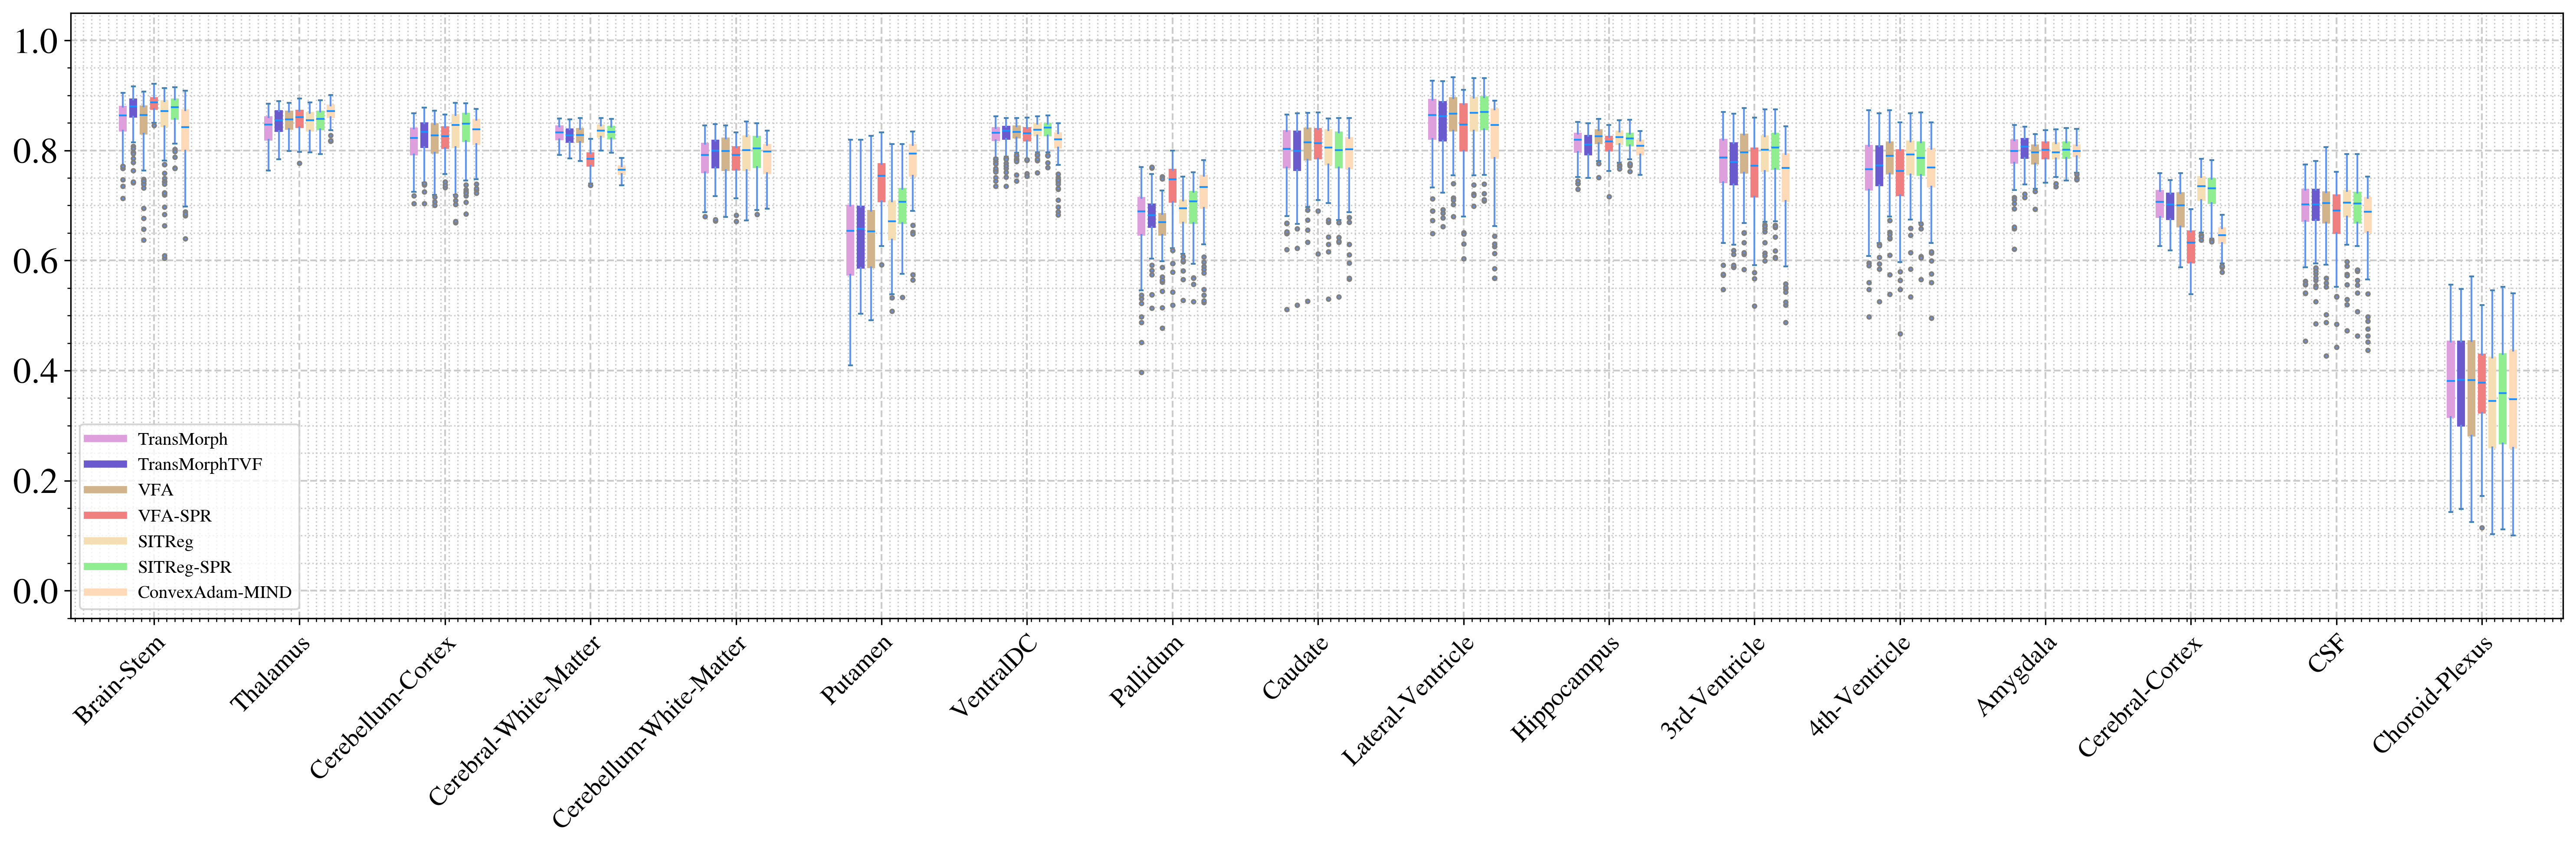

In [12]:
import csv
from pathlib import Path
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import wilcoxon
import pandas as pd

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    for patch in bp['boxes']:
        patch.set(facecolor=color)
    plt.setp(bp['whiskers'], color='cornflowerblue')
    plt.setp(bp['caps'], color='steelblue')
    plt.setp(bp['medians'], color='dodgerblue')

substruct = [
    'Left-Cerebral-White-Matter','Left-Cerebral-Cortex','Left-Lateral-Ventricle','Left-Inf-Lat-Vent','Left-Cerebellum-White-Matter',
    'Left-Cerebellum-Cortex','Left-Thalamus-Proper*','Left-Caudate','Left-Putamen','Left-Pallidum','3rd-Ventricle','4th-Ventricle',
    'Brain-Stem','Left-Hippocampus','Left-Amygdala','CSF','Left-Accumbens-area','Left-VentralDC','Left-vessel','Left-choroid-plexus',
    'Right-Cerebral-White-Matter','Right-Cerebral-Cortex','Right-Lateral-Ventricle','Right-Inf-Lat-Vent','Right-Cerebellum-White-Matter',
    'Right-Cerebellum-Cortex','Right-Thalamus-Proper*','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala',
    'Right-Accumbens-area','Right-VentralDC','Right-vessel','Right-choroid-plexus','5th-Ventricle','WM-hypointensities',
    'non-WM-hypointensities','Optic-Chiasm','CC_Posterior','CC_Mid_Posterior','CC_Central','CC_Mid_Anterior,CC_Anterior'
 ]
outstruct = [
    'Brain-Stem','Thalamus','Cerebellum-Cortex','Cerebral-White-Matter','Cerebellum-White-Matter','Putamen','VentralDC','Pallidum',
    'Caudate','Lateral-Ventricle','Hippocampus','3rd-Ventricle','4th-Ventricle','Amygdala','Cerebral-Cortex','CSF','choroid-plexus'
 ]
outstruct_names = [
    'Brain-Stem','Thalamus','Cerebellum-Cortex','Cerebral-White-Matter','Cerebellum-White-Matter','Putamen','VentralDC','Pallidum',
    'Caudate','Lateral-Ventricle','Hippocampus','3rd-Ventricle','4th-Ventricle','Amygdala','Cerebral-Cortex','CSF','Choroid-Plexus'
 ]

def load_results(csv_path: Path) -> pd.DataFrame:
    with csv_path.open("r") as f:
        rows = list(csv.reader(f))
    if len(rows) < 2:
        raise ValueError(f"Unexpected CSV format in {csv_path}")
    if len(rows[0]) == 1 and 'study_idx' in rows[0][0]:
        header = rows[0][0].split(',')
        data_rows = [r[0].split(',') for r in rows[1:] if r]
    else:
        header = rows[0]
        data_rows = [r for r in rows[1:] if r]
    data = [r for r in data_rows if len(r) >= 2 and r[1] != '']
    df = pd.DataFrame(data, columns=header).apply(pd.to_numeric, errors='coerce')
    if df.empty:
        raise ValueError(f"No valid rows found in {csv_path}")
    return df

def aggregate_structures(df: pd.DataFrame, structures: List[str]) -> np.ndarray:
    agg = np.full((len(structures), len(df)), np.nan)
    columns = [str(c) for c in df.columns]
    for i, stct in enumerate(structures):
        cols = [c for c in columns if stct in c]
        if not cols:
            continue
        agg[i, :] = df[cols].mean(axis=1).to_numpy()
    return agg

all_data = []
all_dsc = []
model_names = list(models_dict.keys())

for exp_name in model_names:
    print(exp_name)
    df = load_results(Path(results_dir) / f"{exp_name}.csv")
    exp_data = aggregate_structures(df, outstruct)
    all_dsc.append(np.nanmean(exp_data, axis=0))
    all_data.append(exp_data)
    ndv = df.iloc[:, -2].to_numpy(dtype=float)
    ndp = df.iloc[:, -1].to_numpy(dtype=float)
    print('Dice: {:.3f}+-{:.3f}, ndv: {:.3f} +- {:.3f}, ndp: {:.3f} +- {:.3f}'.format(np.nanmean(exp_data), np.nanstd(exp_data), np.nanmean(ndv), np.nanstd(ndv), np.nanmean(ndp), np.nanstd(ndp)))

flierprops = dict(marker='o', markerfacecolor='cornflowerblue', markersize=2, linestyle='none', markeredgecolor='grey')
meanprops = {"markerfacecolor": "sandybrown", "markeredgecolor": "chocolate"}
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)
spacing_factor = 14
showmeans = False
sep = 1.0

candidate_colors = [
    'plum','slateblue','tan','lightcoral','wheat','lightgreen','peachpuff','olive','sandybrown','pink',
    'lightskyblue','gold','thistle','salmon','palegreen','khaki','cadetblue','orchid','lightsteelblue','peru'
 ]
n_models = len(all_data)
if n_models == 0:
    raise ValueError("No model results found to plot.")
offsets = np.linspace(-(n_models - 1) / 2, (n_models - 1) / 2, n_models)
plot_specs = list(zip(candidate_colors[:n_models], offsets, all_data, model_names))

preferred_fonts = [
    'Cambria','Times New Roman','Liberation Serif','Nimbus Roman','Nimbus Roman No9 L','DejaVu Serif','STIXGeneral'
 ]
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
font_name = next((f for f in preferred_fonts if f in available_fonts), plt.rcParams.get('font.family', ['DejaVu Sans'])[0])

for color, offset, data, _ in plot_specs:
    bp = plt.boxplot(
        data.T,
        labels=outstruct,
        positions=np.array(range(len(outstruct))) * spacing_factor + sep * offset,
        widths=0.6,
        showmeans=showmeans,
        flierprops=flierprops,
        meanprops=meanprops,
        patch_artist=True,
    )
    set_box_color(bp, color)

plt.grid(linestyle='--', linewidth=1)
for color, _, _, label in plot_specs:
    plt.plot([], c=color, label=label)

font = font_manager.FontProperties(family=font_name, style='normal', size=10)
leg = ax.legend(prop=font)
for line in leg.get_lines():
    line.set_linewidth(4.0)

minor_ticks = np.arange(-10.8, len(outstruct) * spacing_factor, 0.8)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(np.arange(0, 1.05, 0.2))
ax.set_yticks(np.arange(-0.05, 1.05, 0.05), minor=True)
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
plt.xticks(range(0, len(outstruct) * spacing_factor, spacing_factor), outstruct_names, fontsize=14)
plt.yticks(fontsize=20)
for tick in ax.get_xticklabels():
    tick.set_fontname(font_name)
for tick in ax.get_yticklabels():
    tick.set_fontname(font_name)
plt.xlim(-8, len(outstruct) * spacing_factor - 6.2)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.gcf().subplots_adjust(bottom=0.4)
#plt.savefig('analysis', dpi=300)